In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import fxcmpy as fxcmpy
# import product
import itertools as it
import plotly.graph_objects as go
import plotly.express as px
plt.style.use('seaborn')

/var/folders/vt/l70v337s047_p4k5c0kp45200000gn/T/ipykernel_94811/2774093161.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Simple Moving Average Vectorised Backtester Class
##### In this Class, there are two ways of importing data - yahoo finance and FXCM - 
FXCM is preferred as data with minimum precision of 15 minutes can be obtained. However an access key is required for FXCM. For simplicity yahoo-finance can be used 

In [2]:
from itertools import product


class SMABacktester():
    ''' Class for the vectorized backtesting of SMA-based trading strategies.
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, api = None, frequency = 'D1'):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol (instrument) to be backtested
        SMA_S: int
            moving window in bars (e.g. days) for shorter SMA
        SMA_L: int
            moving window in bars (e.g. days) for longer SMA
        start: str
            start date for data import
        end: str
            end date for data import
        api: fxcmpy.fxcmpy object
            if None, data is imported from Yahoo Finance, else data is imported from FXCM trading platform
        frequency: str
            frequency of data (granurality/precision) to be imported from FXCM trading platform
        '''
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None 
        self.api = api
        self.frequency = frequency
        
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
   

    def get_data(self):
        ''' Imports the data from FXCM if api is provided else data is imported from yahoo-Finance.
        '''
        if self.api is None:
            raw = yf.download(self.symbol,self.start,self.end).Close.to_frame()
            raw = raw.rename(columns={'Close':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw
        else:
            raw = self.api.get_candles(self.symbol, start = self.start, end = self.end, period = self.frequency)
            raw = raw['askclose'].to_frame()
            raw = raw.rename(columns={'askclose':'price'})
            raw["returns"] = np.log(raw / raw.shift(1))
            self.data = raw

        
    
    def prepare_data(self):
        '''Prepares the data for strategy backtesting (strategy-specific).
        '''
        data = self.data.copy()
        data["SMA_S"] = data["price"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["price"].rolling(self.SMA_L).mean()
        self.data = data
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and the prepared dataset.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


    def plot_results_plotly(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["creturns"], name='Buy and Hold'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["cstrategy"], name='Strategy'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["price"], name='price'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["SMA_S"], name='SMA_S'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["SMA_L"], name='SMA_L'))
            fig.update_layout(title=title, xaxis_title='Date', yaxis_title='Cumulative Returns')
            fig.show()
            

    def plot_results_plotly(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.symbol, self.SMA_S, self.SMA_L)
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["creturns"], name='Buy and Hold'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["cstrategy"], name='Strategy'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["price"], name='price'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["SMA_S"], name='SMA_S'))
            fig.add_trace(go.Scatter(x=self.results.index, y=self.results["SMA_L"], name='SMA_L'))
            fig.update_layout(title=title, xaxis_title='Date', yaxis_title='Cumulative Returns')
            fig.show()
    
    
    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

        Parameters
        ----------
        SMA_S_range, SMA_L_range: tuple
            tuples of the form (start, end, step size)
        '''
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))
        
        # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results) # best performance
        opt = combinations[np.argmax(results)] # optimal parameters
        
        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.test_strategy()
                   
        # create a df with many results
        many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results
                            
        return opt, best_perf

In [3]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

In [4]:
startDate = '2022-01-01'
endDate = '2022-11-01'
tester = SMABacktester("EUR/USD",10, 30, startDate, endDate,api, frequency = 'D1')


In [5]:
tester.data

,price,returns,SMA_S,SMA_L
date,,,,
2022-01-03 22:00:00,1.12990,NaN,NaN,NaN
2022-01-04 22:00:00,1.12878,-0.000992,NaN,NaN
2022-01-05 22:00:00,1.13166,0.002548,NaN,NaN
2022-01-06 22:00:00,1.13014,-0.001344,NaN,NaN
2022-01-07 22:00:00,1.13624,0.005383,NaN,NaN
...,...,...,...,...
2022-10-27 21:00:00,0.99653,-0.011543,0.989002,0.979852
2022-10-28 21:00:00,0.99680,0.000271,0.990231,0.980761
2022-10-30 21:00:00,0.99508,-0.001727,0.991120,0.981692


In [6]:
tester.test_strategy()

(0.962341, 0.099429)

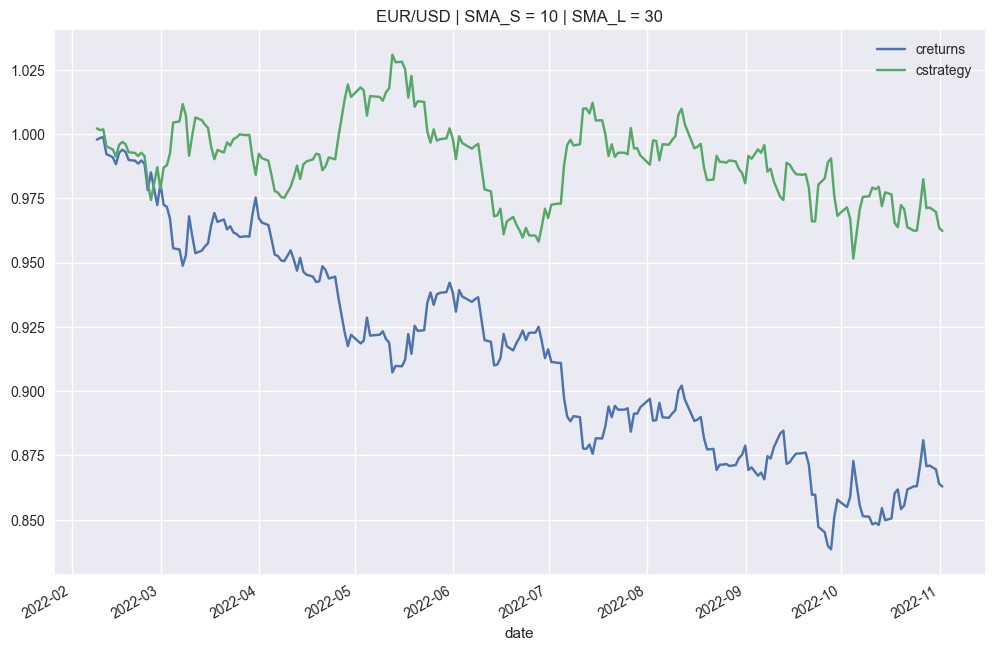

In [7]:
tester.plot_results()

In [8]:
tester.plot_results_plotly()

In [9]:
tester.optimize_parameters((10, 50, 1), (15, 200, 1))

((18, 17), 1.193958)

In [10]:
tester.results.tail(10)

,price,returns,SMA_S,SMA_L,position,strategy,creturns,cstrategy
date,,,,,,,,
2022-10-21 21:00:00,0.98616,0.007226,0.979204,0.979254,-1,0.007226,0.868978,1.147369
2022-10-23 21:00:00,0.98757,0.001429,0.979716,0.979538,1,-0.001429,0.870221,1.145731
2022-10-24 21:00:00,0.98760,0.000030,0.979986,0.978878,1,0.000030,0.870247,1.145765
2022-10-25 21:00:00,0.99686,0.009333,0.979877,0.979353,1,0.009333,0.878407,1.156508
2022-10-26 21:00:00,1.00810,0.011212,0.980950,0.981049,-1,0.011212,0.888311,1.169549
2022-10-27 21:00:00,0.99653,-0.011543,0.981909,0.982358,-1,0.011543,0.878116,1.183127
2022-10-28 21:00:00,0.99680,0.000271,0.983160,0.983696,-1,-0.000271,0.878354,1.182807
2022-10-30 21:00:00,0.99508,-0.001727,0.984329,0.985133,-1,0.001727,0.876838,1.184851
2022-10-31 21:00:00,0.98869,-0.006442,0.985331,0.986155,-1,0.006442,0.871208,1.192509


In [11]:
startDate = '2022-10-01'
endDate = '2022-11-01'